Filename:new_dataset_2.txt
Enter number of clusters:1
Clusters merged: 0 with 1
Clusters merged: 2 with 0,1
Clusters merged: 4 with 5
Clusters merged: 3 with 4,5
Clusters merged: 2,0,1 with 3,4,5
jaccard:  0.5
rand:  0.5


<IPython.core.display.Javascript object>


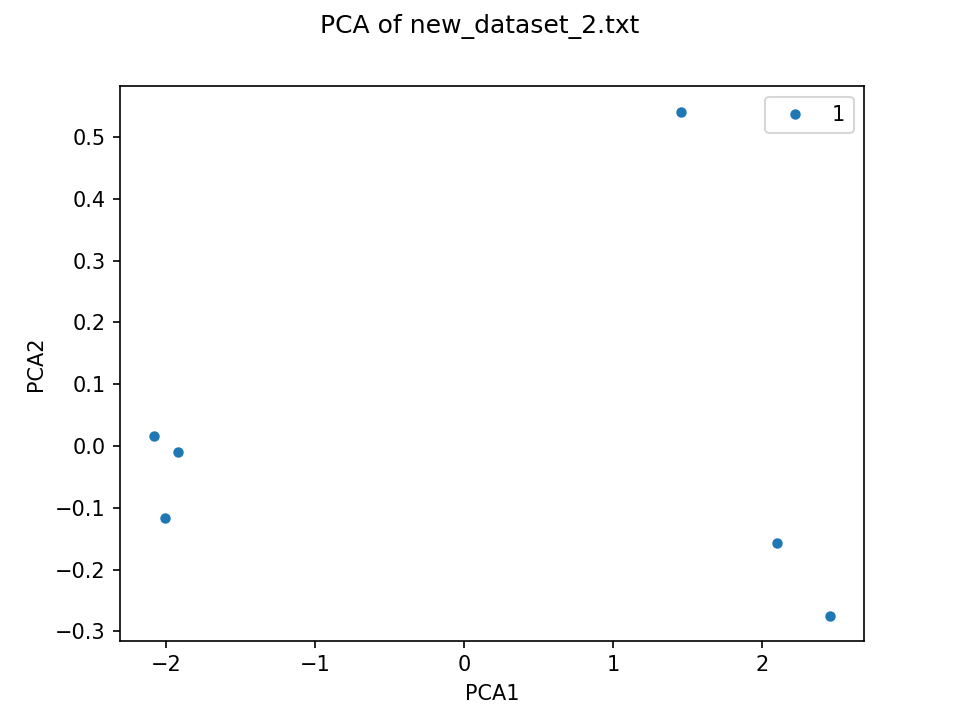

In [15]:
import random
import math 
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def initial_distances():
    for row in range(len(features)):
        distances[str(row)] = {}
        for col in range(len(features)):
            distances[str(row)][str(col)] = {}
            if row == col:
                distances[str(row)][str(col)] = float('inf')
            else:
                value = LA.norm(features[row]-features[col])
                distances[str(row)][str(col)] = value
    return distances
def get_min_dist():
    minRow = 0
    minCol = 0
    min_value = float('inf')
    for row in distances.keys():
        for col in distances[row].keys():
            if distances[row][col] < min_value:
                min_value = distances[row][col]
                minRow = row
                minCol = col
    return minRow,minCol
def combine_new_clusters(min_row,min_col):
    distances[min_row+'&'+min_col] = {}
    print("Clusters merged: "+min_row.replace('&',',')+' with '+min_col.replace('&',','))
    for col in distances.keys():
        min_value=min(distances[min_row][col],distances[min_col][col])
        distances[min_row+'&'+min_col][col] = min_value
        distances[col][min_row+'&'+min_col] = min_value
    distances[min_row+'&'+min_col][min_row+'&'+min_col] = float('inf')

file_name =input("Filename:")
data_1 = np.loadtxt(file_name, delimiter="\t",dtype='str')
data_1=np.asarray(data_1)
features = data_1.astype(np.float)
ground_truth = features[:, 1]
features=np.delete(features, [0,1], 1)
k=int(input("Enter number of clusters:"))
centriods=[]
distances = {}
distances = initial_distances()
while(len(list(distances)) != k):
    minRow,minCol=get_min_dist()
    combine_new_clusters(minRow,minCol)
    del distances[minRow]
    del distances[minCol]
    for row in list(distances):
        del distances[row][minRow]
        del distances[row][minCol]
test_clusters=[None] * len(features)
for cluster in distances.keys():
    points=cluster.split('&')
    for point in points:
        test_clusters[int(point)]=k
    k=k-1
        
################# Analysis ################################################
def get_incidence_matrix(labels):
    incidence_matrix = np.zeros((len(labels),len(labels)))
    for i in range(len(labels)):
        for j in range(len(labels)):
            incidence_matrix[i][j] = 1 if labels[i] == labels[j] else 0
    return incidence_matrix

def get_data_count(G, A):
    m11 = m00 = m10 = m01 = 0.0
    for i in range(len(G)):
        for j in range(len(G)):
            if G[i][j] == 1 and A[i][j] == 1:
                m11 += 1
            elif G[i][j] == 0 and A[i][j] == 0:
                m00 += 1
            elif G[i][j] == 0 and A[i][j] == 1:
                m10 += 1
            elif G[i][j] == 1 and A[i][j] == 0:
                m01 += 1
                
    return m11, m00, m10, m01

def jaccard(m11,m10,m01):
    return m11/(m11 + m10 + m01)

def rand(m00,m11,m10,m01):
    return (m00 + m11)/(m00 + m11 + m10 + m01)

# print(ground_truth)
# print(test_clusters)
ground_truth_matrix = get_incidence_matrix(ground_truth)
# print(ground_truth_matrix)
actual_cluster_matrix = get_incidence_matrix(test_clusters)
# print(tes)

m11,m00,m10,m01 = get_data_count(ground_truth_matrix, actual_cluster_matrix)
print('jaccard: ', jaccard(m11,m10,m01))
print('rand: ', rand(m00,m11,m10,m01))
################# PCA Visualization ################################################
data = np.loadtxt(file_name, delimiter="\t",dtype='str')
features_count = len(data[0])-1

data = np.asmatrix(data)
features = np.delete(data,[0,1],1)
features = features.astype(np.float)
labels = data[:, features_count]

mean_features = np.mean(features, axis=0)
adjusted_data = features - mean_features
covariance_matrix = np.cov(adjusted_data.T)

w, v = LA.eig(covariance_matrix)

w = w.argsort()[::-1][:2]
v = v[:,w]

principal_components = adjusted_data * v
principal_components = np.asarray(principal_components)

labels = test_clusters
df = pd.DataFrame(dict(xAxis=principal_components[:,0], yAxis=principal_components[:,1], label=labels))
diesase_groups = df.groupby('label')
    
fig, ax = plt.subplots()
fig.suptitle('PCA of ' + file_name)
for disease, diesase_group in diesase_groups:
    ax.plot(diesase_group.xAxis, diesase_group.yAxis, marker='o', linestyle='', ms=4, label=disease)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax.legend()
plt.savefig('PCA_' + os.path.splitext(os.path.basename(file_name))[0] + ".png", dpi = 400)
plt.show()